# NLOS with HHL

## 1. NLOS Test case generation

### Layout of testcase generation

1. Set SV at origin $(0, 0, 0)$
1. Based on $r_{min}$ and $r_{max}$, generate random HV position. `numpy.random.rand()` is used. 
1. Randomly create total of `num_points` points, each point's distance being farther away than $d_{min}$ but closer to each points than $d_{max}$.
1. Compute necessary quantities($\phi, \, \psi,\, \text{etc...}$)

In [1]:
import numpy as np

In [42]:
def dist(a: np.ndarray, b: np.ndarray):
    if a.shape != b.shape:
        raise ValueError("inconsistent point shape")
    return np.sqrt(np.sum((a - b) ** 2))

In [43]:
class NLOStestcase:
    """
    One randomized test case (NLOS geometry). Does not enforce NLOS by itself,
    just generates geometry.
    """
    def __init__(self: "NLOStestcase", sample_point_cnt: int, HV_r_min: float, HV_r_max: float, 
                 sample_r_min: float, sample_r_max: float, HV_orientation: float | None = None,
                 HV: tuple[float, float, float] | None = None, sample_points: tuple | list | None = None):
        
        if HV_r_min < 0 or HV_r_max < 0 or HV_r_min > HV_r_max:
            raise ValueError("HV radius restriction inappropriate")
        if HV_orientation is not None and (HV_orientation < 0 or HV_orientation > 2 * np.pi):
            raise ValueError("Inappropriate HV orientation")
        if sample_r_min < 0 or sample_r_max < 0 or sample_r_max < sample_r_min:
            raise ValueError("sample point distance restriction inappropriate")
        if sample_point_cnt <= 0:
            raise ValueError(f"Too small sample_point_cnt: {sample_point_cnt}")
        if (sample_points is not None and len(sample_points) != sample_point_cnt):
            raise ValueError("Sample point count/actual list mismatch")

        self.SV = np.zeros(3)

        self.sample_r_min = sample_r_min
        self.sample_r_max = sample_r_max
        
        if HV is None:
            self.HV = self._sample_point_in_shell(HV_r_min, HV_r_max)
            # print(f"HV position set randomly: {self.HV}")
        else:
            self.HV = HV
            # print(f"HV position set to given parameter: {self.HV}")
        
        if HV_orientation is None:
            self.HV_orientation = np.random.random() * 2 * np.pi
        else:
            self.HV_orientation = HV_orientation

        # if dist between HV and SV is greater than sample_r_max * 2, throw
        # print("SV: {0}, HV: {1}".format(self.HV, self.SV))
        if dist(self.HV, self.SV) > sample_r_max * 2.5:
            raise ValueError("sample_r_max is too small")
        
        # set the reflection sample points
        self.sample_point_cnt = sample_point_cnt
        if sample_points is None:
            points = set()
            while len(points) < self.sample_point_cnt:
                point = self._sample_point_in_shell(sample_r_min, sample_r_max)
                if sample_r_min < dist(point, self.HV) < sample_r_max:
                    points.add(tuple(point))
            self.sample_points = [np.array(x) for x in points]
        else:
            self.sample_points = sample_points

        # convert each point to NLOS-used spherical coordinates
        self.sample_spherical_points = []
        for x in self.sample_points:
            self.sample_spherical_points.append(np.array(self._to_NLOS_coordinates(x)))
        
        # add rho * c(time difference) to last array member
        self._add_rho()

        # sort by dist
        self.sample_spherical_points.sort(key=lambda x: x[0])

        # initialize
        self.A = np.zeros((3 * (self.sample_point_cnt - 1), (self.sample_point_cnt + 1)))
        self.b = np.zeros((3 * (self.sample_point_cnt - 1),))

        # todo: change this
        self.omega = self.HV_orientation

    def _random_direction_3d(self) -> np.ndarray:
        """
        Sample a random direction uniformly on the unit sphere S^2.
        """
        v = np.random.normal(size=3)
        norm = np.linalg.norm(v)
        if norm < 1e-12:
            # extremely unlikely; resample if it happens
            return self._random_direction_3d()
        return v / norm
    
    def _sample_point_in_shell(self, r_min: float, r_max: float) -> np.ndarray:
        """
        Sample a random 3D point whose distance from the origin is in [r_min, r_max].
        Direction is uniform; radius is uniform in [r_min, r_max] (not volume-uniform).
        """
        direction = self._random_direction_3d()
        r = r_min + (r_max - r_min) * np.random.rand()
        return r * direction
    
    def _cartesian_to_spherical(self, point: np.ndarray):
        r = dist(np.array([0, 0, 0]), point)
        rho = np.sqrt(np.sum(point[:2] ** 2))
        phi = np.arctan2(point[1], point[0])
        psi = np.arctan2(rho, point[2])
        return r, phi, psi
    
    def _to_NLOS_coordinates(self, point: np.ndarray):
        """returns d, v, theta, vartheta, phi, psi"""
        v, theta, var_theta = self._cartesian_to_spherical(point)
        v_p, phi_p, psi = self._cartesian_to_spherical(point - self.HV)
        
        phi = phi_p - self.HV_orientation
        if phi < 0: 
            phi += 2 * np.pi

        return (v + v_p, v, theta, var_theta, phi, psi, 0)
    
    def _add_rho(self):
        d_1 = min([x[0] for x in self.sample_spherical_points])
        for x in self.sample_spherical_points:
            x[-1] = x[0] - d_1

    def set_A(self, omega):
        # self sphereical points:
        # d, v, theta, var_theta, phi, psi, rho * c
        # 0, 1, 2,     3,         4,   5,   6
        
        # first point
        p1 = self.sample_spherical_points[0]

        # x direction matrix: assume point list is sorted
        for i, x in enumerate(self.sample_spherical_points[1:]):
            # - ( sin(var_theta) * cos(theta) + sin(psi) cos(phi+w) )
            self.A[i, 0] = -(np.sin(p1[3]) * np.cos(p1[2]) + np.sin(p1[5]) * np.cos(p1[4] + omega))

            # sin(var_theta) * cos(theta) + sin(psi) cos(phi+w)
            self.A[i, i + 1] = (np.sin(x[3]) * np.cos(x[2]) + np.sin(x[5]) * np.cos(x[4] + omega))
            
            # sin(psi_1) cos(phi_1 + omega) - sin(psi_p) cos(phi_p + omega)
            self.A[i, self.sample_point_cnt] = np.sin(p1[5]) * np.cos(p1[4] + omega) - np.sin(x[5]) * np.cos(x[4] + omega)
        
        # y direction matrix
        for i, x in enumerate(self.sample_spherical_points[1:]):
            self.A[(self.sample_point_cnt - 1) + i, 0] = -(np.sin(p1[3]) * np.sin(p1[2]) + np.sin(p1[5]) * np.sin(p1[4] + omega))

            self.A[(self.sample_point_cnt - 1) + i, i + 1] = (np.sin(x[3]) * np.sin(x[2]) + np.sin(x[5]) * np.sin(x[4] + omega))

            self.A[(self.sample_point_cnt - 1) + i, self.sample_point_cnt] = np.sin(p1[5]) * np.sin(p1[4] + omega) - np.sin(x[5]) * np.sin(x[4] + omega)
        
        # z direction matrix
        for i, x in enumerate(self.sample_spherical_points[1:]):
            self.A[(self.sample_point_cnt - 1) * 2 + i, 0] = -(np.cos(p1[3]) + np.cos(p1[5]))

            self.A[(self.sample_point_cnt - 1) * 2 + i, i + 1] = (np.cos(x[3]) + np.cos(x[5]))
            
            self.A[(self.sample_point_cnt - 1) * 2 + i, self.sample_point_cnt] = np.cos(p1[5]) - np.cos(x[5])

    def set_b(self, omega):
        # self sphereical points:
        # d, v, theta, var_theta, phi, psi, rho * c
        # 0, 1, 2,     3,         4,   5,   6

        # x direction
        for i, x in enumerate(self.sample_spherical_points[1:]):
            self.b[i] = x[6] * np.sin(x[5]) * np.cos(x[4] + omega)
        
        # y direction
        for i, x in enumerate(self.sample_spherical_points[1:]):
            self.b[(self.sample_point_cnt - 1) + i] = x[6] * np.sin(x[5]) * np.sin(x[4] + omega)
        
        # z direction
        for i, x in enumerate(self.sample_spherical_points[1:]):
            self.b[(self.sample_point_cnt - 1) * 2 + i] = x[6] * np.cos(x[5])

## 2. NLOS Preparation

### Method for obtaining $\omega$

$\omega$ is required to determine $\textbf{A}(\omega)$ and $\textbf{B}(\omega)$.

$\omega$ is determined by the equation $\text{null}(\textbf{A}(\omega)^\text{T})^\text{T} \textbf{B}(\omega)=0$.

Current implementation: Linear search

In [44]:
testcase = NLOStestcase(4, 10, 15, 8, 12)
testcase.set_A(testcase.omega)
testcase.set_b(testcase.omega)
print(testcase.HV)
print("-----------", testcase.A, "-------------", testcase.b, "------------", sep='\n')
classic_sol = np.linalg.lstsq(testcase.A, testcase.b)[0]
print(classic_sol)
print([x[1] for x in testcase.sample_spherical_points])

[-7.88620948 -5.60607342  3.08316996]
-----------
[[-0.47962729 -0.80971294  0.          0.          0.63697734]
 [-0.47962729  0.         -0.74992202  0.          0.63546296]
 [-0.47962729  0.          0.          1.0185189  -0.19324152]
 [ 1.13970393  0.60945352  0.          0.         -0.83069273]
 [ 1.13970393  0.          1.49302155  0.         -1.23852013]
 [ 1.13970393  0.          0.         -1.33431975  0.10993303]
 [ 1.09440438 -1.34290203  0.          0.          0.10479474]
 [ 1.09440438  0.          0.41831262  0.         -0.74778335]
 [ 1.09440438  0.          0.         -0.44852088 -0.34012107]]
-------------
[ 0.02566118  0.06925682  2.0755301   0.44649107  1.95029093 -0.84099554
 -0.60972191  0.09032554 -0.86807648]
------------
[ 8.70860485  8.95424745  9.57372286  9.55005983 17.98009921]
[np.float64(8.708604847673252), np.float64(8.954247450318048), np.float64(9.573722864840974), np.float64(9.550059831173659)]


## 3. HHL Implementation

### Defs

In [45]:
import math
import numpy as np
import qiskit
from scipy.linalg import expm
from qiskit.circuit.library import StatePreparation, ExactReciprocalGate, phase_estimation
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.result import Result
from qiskit.circuit import IfElseOp, QuantumCircuit, QuantumRegister, ClassicalRegister, Gate
from qiskit.circuit.library import Initialize , UnitaryGate , QFTGate, ExactReciprocalGate, UCRYGate

from qiskit.quantum_info.operators.predicates import is_unitary_matrix

In [46]:
def progress_callback(**kwargs):
    pass_name = kwargs['pass_'].name()
    count = kwargs['count']
    # The DAG circuit is an internal representation that can be inspected
    dag = kwargs['dag'] 
    print(f"Pass {count}: {pass_name}, Operations: {dag.count_ops()}")


def hhl_fidelity(x_classic, probs_hhl):
    # Classical solution
    x = x_classic / np.linalg.norm(x_classic)

    # Rebuild complex vector from probabilities (up to global phase)
    # HHL gives only magnitudes; pick sign so inner product is maximized
    # Just treat as positive real for fidelity purposes

    probs_classical = np.abs(x) ** 2
    probs_classical = probs_classical / probs_classical.sum()

    # Normalize HHL probs just in case
    probs_hhl = probs_hhl / probs_hhl.sum()

    # Probability "fidelity" (Bhattacharyya coefficient)
    fidelity = float(np.sum(np.sqrt(probs_classical * probs_hhl)))
    # Numerical safety for arccos
    fidelity_clamped = max(min(fidelity, 1.0), -1.0)
    angle = float(np.rad2deg(np.arccos(fidelity_clamped)))

    return fidelity, angle

In [47]:
class CustomExactReciprocalGate(Gate):

    def __init__(
        self, num_state_qubits: int, scaling: float, neg_vals: bool = False, kappa: float | None = None, cutoff_ratio: float = 2.0, label: str = "1/x"
    ) -> None:
        super().__init__("CustomExactReciprocal", num_state_qubits + 1, [], label=label)

        self.scaling = scaling
        self.neg_vals = neg_vals
        self.kappa = kappa
        self.cutoff_ratio = cutoff_ratio
    
    def _f_lambda(self, lam: float) -> float:
        def f_original(lam):
            if math.isclose(self.scaling / lam, 1.0, abs_tol=1e-05):
                return 1.0
            elif self.scaling / lam < 1.0:
                return self.scaling / lam
            return 0.0

        if self.kappa is None:
            return f_original(lam)
        
        # original HHL paper for f(lambda)
        # if 1/kap_p < lambda < 1/kap: transition area
        # if lambda < 1/kap_p: too small lambda, don't rotate
        # if lamdba > 1/kap: good lambda, behave like original HHL
        kap = self.kappa
        kap_p = kap * self.cutoff_ratio

        # good area
        if lam >= 1 / kap:
            return f_original(lam)

        # bad area: not rotate at all
        if lam < 1 / kap_p:
            return 0.0
        
        # transition area
        t = (lam - 1 / kap_p) / (1 / kap - 1 / kap_p)
        return f_original(1 / kap) * math.sin(0.5 * math.pi * t)



    def _define(self):
        num_state_qubits = self.num_qubits - 1
        qr_state = QuantumRegister(num_state_qubits, "state")
        qr_flag = QuantumRegister(1, "flag")
        circuit = QuantumCircuit(qr_state, qr_flag)

        angles = [0.0]
        nl = 2 ** (num_state_qubits - 1) if self.neg_vals else 2**num_state_qubits

        # Angles to rotate by scaling / x, where x = i / nl
        for i in range(1, nl):
            lam = i / nl
            f = self._f_lambda(lam)
            if math.isclose(f, 1.0, abs_tol = 1e-5):
                angles.append(np.pi)
            elif f <= 0.0:
                angles.append(0.0)
            else:
                angles.append(2 * math.asin(f))

        circuit.append(UCRYGate(angles), [qr_flag[0]] + qr_state[: len(qr_state) - self.neg_vals])

        if self.neg_vals:
            circuit.append(
                UCRYGate([-theta for theta in angles]).control(),
                [qr_state[-1]] + [qr_flag[0]] + qr_state[:-1],
            )
            angles_neg = [0.0]
            for i in range(1, nl):
                lam_neg = -(1.0 - i / nl)
                lam = abs(lam_neg)
                f = self._f_lambda(lam)

                if math.isclose(f, 1.0, abs_tol = 1e-5):
                    angles_neg.append(-np.pi)
                elif f <= 0.0:
                    angles_neg.append(0.0)
                else:
                    angles_neg.append(-2 * math.asin(f))

            circuit.append(
                UCRYGate(angles_neg).control(), [qr_state[-1]] + [qr_flag[0]] + qr_state[:-1]
            )

        self.definition = circuit

In [48]:
class HHL:
    """class that implements HHL algorithm"""

    def __init__(self, A: np.typing.NDArray, b: np.typing.NDArray, state_dim: int = -1, tol=1e-05, lambda_min_eff=1e-01, force_cutoff=None):
        """A: operator matrix, b: matrix, n: number of qubits
        force_cutoff: 
            - True - Always use cutoff based on lambda_min_eff
            - None - use cutoff if eigval is  on lambda_min_eff
            - False - do not use cutoff at all times.
        """
        assert (len(A.shape) == 2 and len(b.shape) == 1), "Inconsistent dimension of A or b"
        assert (A.shape[0] == b.shape[0]), "shape of A does not match b"
        
        self.A = A.copy()
        self.b = b.copy()
        self.lambda_min_eff = lambda_min_eff

        if (self.A.shape[0] != self.A.shape[1] or not np.allclose(self.A, self.A.conj().T, atol=tol)):
            # if (self.A.shape[0] != self.A.shape[1]):
            #     print("A is not a square matrix")
            # else:
            #     print("A is not Hermitian")
            self.A = np.block([[np.zeros((self.A.shape[0], self.A.shape[0])), self.A],
                               [self.A.conj().T, np.zeros((self.A.shape[1], self.A.shape[1]))]])
            # print("A is evaluated as [[0, A], [AT, 0]]")
            # print("-----------------------------------")
            self.b = np.block([b, np.zeros(A.shape[1])])
        
        # pad A to be 2^n
        self.n_b = 0
        while (self.A.shape[0] > (1 << self.n_b)):
            self.n_b += 1
        
        if (self.A.shape[0] != (1 << self.n_b)):
            # print("A is not power of 2, pad to make A {0} * {0}".format((1 << self.n_b)))
            # print("-----------------------------------")
            pad = (1 << self.n_b) - self.A.shape[0]

            self.A = np.pad(self.A, ((0, pad), (0, pad)), "constant", constant_values=0)
            self.b = np.pad(self.b, (0, (1 << self.n_b) - self.b.shape[0]), "constant", constant_values=0)

        self.tol = tol
        self.dim = (1 << self.n_b)

        self.b_norm = 1

        if (not math.isclose(np.linalg.norm(self.b), 1, abs_tol=tol)):
            self.b_norm = np.linalg.norm(self.b)
            self.b = self.b.copy() / np.linalg.norm(self.b)
            # print(f"b is not normalized, normalized to b = {self.b} during init")
            # print("-----------------------------------")
        
        eigvals = np.linalg.eigvalsh(self.A)

        if force_cutoff or (force_cutoff is None and np.abs(eigvals).min() < lambda_min_eff):
            if not any(np.abs(eigvals) > lambda_min_eff):
                raise ValueError("lambda_min_eff is too big, all eigvals are smaller")
            
            lambda_min = np.abs(eigvals)[np.abs(eigvals) > lambda_min_eff].min()
            self.cutoff = True
            # print(f"chosen mode: {force_cutoff}\nCutoff enabled: lambda_min_eff - {lambda_min_eff}, min(eigvals) - {np.abs(eigvals).min()}")

        else:
            lambda_min = np.abs(eigvals).min()
            self.cutoff = False
        #     print(f"chosen mode: {force_cutoff}\nCutoff disabled")
        # print("-----------------------------------")

        # C for making C/λ < 1
        self.C = lambda_min * 0.9

        self.kappa = np.abs(eigvals).max() / lambda_min # characteristic number of matrix A
        # define t slightly smaller -> then if eigval is positive, < 0.45 and negative, > 0.55
        # if just pi / |lambda_max| -> 0.5 eigval errors
        self.t = np.pi / np.abs(eigvals).max() / 1.5 # calculate t

        self.phase_min_eff = lambda_min * self.t / (2 * np.pi)

        if (state_dim > 0):
            self.state_dim = state_dim
        else:
            if self.kappa < 100 and int(np.log2(self.kappa)) + 2 < 10:
                self.state_dim = int(np.log2(self.kappa))
            else:
                self.state_dim = 6

        self.U = expm(1j * self.t * self.A) # U = e^(iAt), then convert to unitarygate
    
    def _create_register(self):
        """call this to initially create registers, only once"""
        b_reg = QuantumRegister(self.n_b, 'sys')
        c_reg = QuantumRegister(self.state_dim, 'phase')
        aux_reg = QuantumRegister(1, 'aux')
        sign_reg = QuantumRegister(1, 'sign')
        classic_aux_reg = ClassicalRegister(1, 'classic_aux')
        result_reg = ClassicalRegister(self.n_b, 'classic_sys')
        return b_reg, c_reg, aux_reg, sign_reg, classic_aux_reg, result_reg


    def _prepare_state(self, circ: QuantumCircuit, b_reg: QuantumRegister):
        """add gate to mount b on registers"""
        # assert math.isclose(np.linalg.norm(self.b), 1, abs_tol=self.tol) # check if b is normalized
        temp_circ = QuantumCircuit(QuantumRegister(self.n_b, 'temp'))
        init_gate = StatePreparation(Statevector(self.b))
        temp_circ.append(init_gate, temp_circ.qubits)
        temp_gate = temp_circ.to_gate()
        temp_gate.label = "|b⟩ state preparation"
        circ.append(temp_gate, b_reg) # add gate for initalizing b
        circ.barrier() # separation from rest of the process

    def _assign_neg_sign(self, circ, c_reg, sign_reg):
        phase_le = list(reversed(c_reg)) # since qpe gives us big-endian, should reverse/little-endian expected in ExactReciprocalGate
        # if the most-significant bit(msb) is 1 -> phase > 1
        # therefore sign must be 1
        # if msb = 1 -> set sign to 1(controlled-not on sign_reg)
        circ.cx(phase_le[-1], sign_reg[0])
        

    def _controlled_rotation(self, circ: QuantumCircuit, c_reg: QuantumRegister, aux_reg: QuantumRegister, sign_reg: QuantumRegister):
        """add controlled rotation block to circuit"""
        # neg_vals = True: eigvals may be negative
        # if negative, ExactReciprocalGate expects sign qubit to be 1
        # and the phase to be (1 - phase)
        # switch to negative if sign = 1 in _assign_neg_sign

        # todo: choose the right kappa
        if self.cutoff:
            rot_gate = CustomExactReciprocalGate(
                num_state_qubits=self.state_dim + 1,
                scaling=self.C * self.t / (2 * np.pi),
                neg_vals=True,
                kappa=1 / self.phase_min_eff,
                cutoff_ratio=2.0
            )
        else:
            # rot_gate = CustomExactReciprocalGate(
            #     num_state_qubits=self.state_dim + 1,
            #     scaling=self.C * self.t / (2 * np.pi),
            #     neg_vals=True,
            #     kappa=None,
            # )
            rot_gate = ExactReciprocalGate(
                num_state_qubits=self.state_dim + 1, 
                scaling=self.C * self.t / (2 * np.pi), 
                neg_vals=True,
                label="Controlled-Y"
            )

        circ.append(rot_gate, [*sign_reg, *reversed(c_reg), *aux_reg])
    

    def _qpe(self, circ: QuantumCircuit, b_reg, c_reg, inverse=False):
        """add QPE/IQPE gate to the circuit"""
        qpe_circ = phase_estimation(self.state_dim, Operator(self.U).to_instruction())
        if (inverse):
            qpe_circ = qpe_circ.inverse()
        qpe_gate = qpe_circ.to_gate()
        qpe_gate.label = "QPE"
        if (inverse):
            qpe_gate.label="IQPE"
        circ.append(qpe_gate, [*c_reg, *b_reg]) # order may change


    def _measure(self, circ: QuantumCircuit, aux_reg: QuantumRegister, b_reg: QuantumRegister, classic_aux_reg: ClassicalRegister, result_reg: ClassicalRegister):
        """measure the quantum qubits and store in classic bits"""
        circ.measure(aux_reg, classic_aux_reg)
        circ.measure(b_reg, result_reg)

    def make_circuit(self):
        """function to create circuit. required to be executed before run and transpile"""
        b_reg, c_reg, aux_reg, sign_reg, classic_aux_reg, result_reg = self._create_register()


        circ = QuantumCircuit(aux_reg, c_reg, b_reg, sign_reg, result_reg, classic_aux_reg)
        self._prepare_state(circ, b_reg)
        self._qpe(circ, b_reg, c_reg, inverse=False)
        circ.barrier()
        # check if phase is negative
        self._assign_neg_sign(circ, c_reg, sign_reg)
        circ.barrier()
        self._controlled_rotation(circ, c_reg, aux_reg, sign_reg)
        circ.barrier()
        self._assign_neg_sign(circ, c_reg, sign_reg)
        circ.barrier()
        self._qpe(circ, b_reg, c_reg, inverse=True)
        circ.barrier()
        self._measure(circ, aux_reg,  b_reg, classic_aux_reg, result_reg)

        return circ

    def transpile(self, circ, simulator=AerSimulator, show_progress=False):
        self.backend = simulator()
        if (show_progress):
            return transpile(circ, backend=self.backend, callback=progress_callback), circ
        return transpile(circ, backend=self.backend)
    
    def run(self, circ, shots=1) -> Result:
        try:
            return self.backend.run(circ, shots=shots).result()
        except AttributeError:
            raise AttributeError("Circuit is not Transpiled before running")
    
    def transpile_and_run(self, shots=1):
        transpiled_circ = self.transpile()
        return self.run(transpiled_circ, shots=shots).result()
    
    def analyze(self, result: Result, show_counts=False) -> tuple[float, np.ndarray]:
        count = result.get_counts()

        if (isinstance(count, dict)):
            if show_counts:
                print(count)
            success = {res: cnt for res, cnt in count.items() if res.split()[0] == '1'}
            # failure = {res: cnt for res, cnt in count.items() if res.split()[0] == '0'}
            tot = sum(success.values())
            success_rate = tot / sum(count.values())
            
            x = np.zeros((1 << self.n_b), dtype=float)
            for res, cnt in success.items():
                ind = int(res.split()[1], 2)
                x[ind] = cnt / tot

            return success_rate, x
        else:
            print(count)
            raise TypeError("result.get_counts() is not type dict[str, int]")
    
    def norm(self, success_rate):
        return np.sqrt(success_rate) / self.C * self.b_norm * 2

### HHL Test Example

In [49]:
    # [1, 2, 0],
    # [2, 1, 3],
    # [0, 3, 2]
A = np.array([
    [1, 2, 0, 1],
    [2, 1, 3, -1],
    [0, 3, 2, 4],
    [1, -1, 4, 4],
], dtype=float)
b = np.array([2, 5, -10, 3], dtype=float)

alg = HHL(A, b, lambda_min_eff=1e-1, force_cutoff=None)

print(np.linalg.eigvalsh(alg.A))

[-3.83476114  0.88196357  3.4106229   7.54217467]


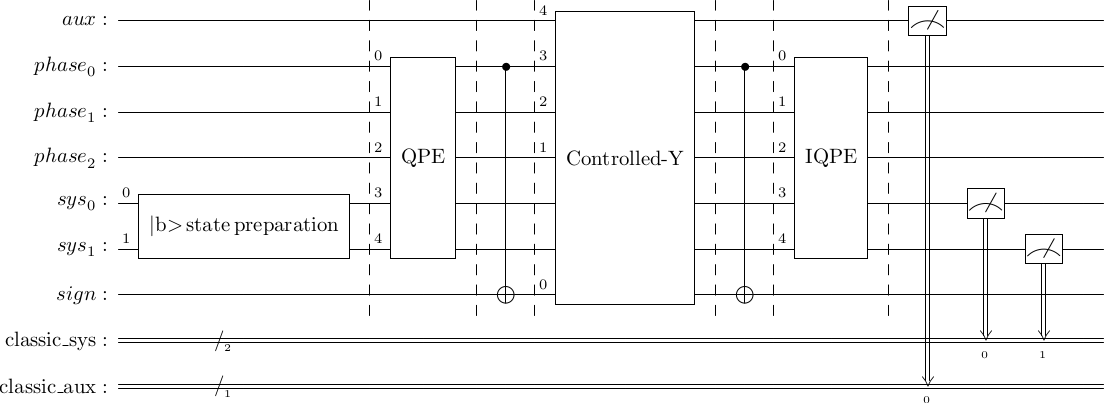

In [50]:
circ = alg.make_circuit()
transpiled_circ = alg.transpile(circ, show_progress=False)
circ.draw(output="latex", filename="HHL.pdf")

In [51]:
# classic
try:
    x_classic = np.linalg.solve(alg.A, alg.b)
except np.linalg.LinAlgError as e:
    print(f"Failed to solve classically, {e.args}")
    x_classic = np.linalg.lstsq(alg.A, alg.b)[0] # first: singular value of A
except Exception as e:
    raise ValueError(f"Failed to solve: {e.args}")
print(x_classic)

for shots in [10**x for x in range(3, 7)]:
    print(f"shots: {shots}")
    result = alg.run(transpiled_circ, shots=shots)

    p, x = alg.analyze(result, show_counts=False)
    print(f"success rate: {p}\n{x}")
    fidelity, deg = hhl_fidelity(x_classic, x)
    print(f"Fidelity: {fidelity}, angle: {deg}")
    print("Classical Norm: {0}, HHL-based norm: {1}".format(np.linalg.norm(x_classic), math.sqrt(p) / alg.C) * 2)



print(x_classic ** 2 / np.linalg.norm(x_classic) ** 2)

[ 0.57043972 -0.21330336 -0.15850984  0.02641831]
shots: 1000
success rate: 0.028
[0.10714286 0.28571429 0.32142857 0.28571429]
Fidelity: 0.6425614385565617, angle: 50.01691422306785
Classical Norm: 0.6298595830750704, HHL-based norm: 0.21080740422445335Classical Norm: 0.6298595830750704, HHL-based norm: 0.21080740422445335
shots: 10000
success rate: 0.0415
[0.22409639 0.34216867 0.23855422 0.19518072]
Fidelity: 0.768270338400005, angle: 39.80118018302649
Classical Norm: 0.6298595830750704, HHL-based norm: 0.25664386869940037Classical Norm: 0.6298595830750704, HHL-based norm: 0.25664386869940037
shots: 100000
success rate: 0.03768
[0.20514862 0.32192144 0.24761146 0.22531847]
Fidelity: 0.7474857548647943, angle: 41.626946933739376
Classical Norm: 0.6298595830750704, HHL-based norm: 0.24454697328107Classical Norm: 0.6298595830750704, HHL-based norm: 0.24454697328107
shots: 1000000
success rate: 0.037863
[0.20127829 0.31767161 0.26875842 0.21229168]
Fidelity: 0.7469791507202498, angle: 4

## 4. Apply HHL to NLOS

### 4.1 Solve using HHL

In [12]:
# linear_solver = HHL(testcase.A, testcase.b, lambda_min_eff=0.001, force_cutoff=True)
# circ = linear_solver.make_circuit()
# circ_trans = linear_solver.transpile(circ)

In [13]:
# n = testcase.sample_point_cnt
# result = linear_solver.run(circ_trans, 10**6)
# p, x = linear_solver.analyze(result)

# # return to the original state
# x = np.sqrt(x) * linear_solver.norm(p)
# print(linear_solver.norm(p))

# z = x[(n - 1) * 3:-(linear_solver.A.shape[0] - 3 * (n - 1) - (n + 1))]
# print(p, x, z, sep = '\n')
# print('\n')
# print(np.sqrt(np.average((classic_sol - z) / classic_sol) ** 2))
# print(np.acos(classic_sol @ z / np.linalg.norm(classic_sol) / np.linalg.norm(z)) * 360 / 2 / np.pi)
# print('\n')
# print(np.average(classic_sol / z))

### 4.2 Newly defined class 

In [14]:
from qiskit_aer.library import SaveState
from collections import defaultdict

In [15]:
class HHLwithSWAP(HHL):
    def _get_statevector_hhl(self):
        # registers
        b_reg, c_reg, aux_reg, sign_reg, classic_aux_reg, result_reg = self._create_register()

        circ = QuantumCircuit(aux_reg, b_reg, c_reg, sign_reg)
        self._prepare_state(circ, b_reg)
        self._qpe(circ, b_reg, c_reg, inverse=False)
        circ.barrier()
        # check if phase is negative
        self._assign_neg_sign(circ, c_reg, sign_reg)
        circ.barrier()
        self._controlled_rotation(circ, c_reg, aux_reg, sign_reg)
        circ.barrier()
        self._assign_neg_sign(circ, c_reg, sign_reg)
        circ.barrier()
        self._qpe(circ, b_reg, c_reg, inverse=True)
        circ.barrier()
        circ.append(SaveState(circ.num_qubits, label="after_hhl"), [*aux_reg, *b_reg, *c_reg, *sign_reg])
        

        transpiled_hhl = self.transpile(circ)
        sim = AerSimulator(method="statevector")
        result: Result = sim.run(transpiled_hhl, shots=1).result()
        full_statevector = Statevector(result.data(0)["after_hhl"])

        vec = full_statevector.to_dict()
        tot_n = circ.num_qubits

        anc_idx = tot_n - 1 - circ.find_bit(aux_reg[0]).index
        b_indices = [tot_n - 1 - circ.find_bit(q).index for q in b_reg]
        c_indices = [tot_n - 1 - circ.find_bit(q).index for q in c_reg]
        sign_idx = tot_n - 1 - circ.find_bit(sign_reg[0]).index

        branch_amps: dict[tuple[str, str], np.ndarray] = defaultdict(
            lambda: np.zeros(1 << self.n_b, dtype=complex)
        )

        p_succ = 0
        for bitstring, amp in vec.items():
            if bitstring[anc_idx] != '1':
                continue
            
            p_succ += abs(amp) ** 2

            c_bits = ''.join(bitstring[p] for p in sorted(c_indices))
            s_bit = bitstring[sign_idx]
            branch_key = (c_bits, s_bit)

            # Build integer index for b-register
            b_bits = ''.join(bitstring[p] for p in sorted(b_indices))
            b_idx = int(b_bits, 2)

            branch_amps[branch_key][b_idx] += amp
        
        self.success_rate = p_succ
        branch_probs = {
            key: np.sum(np.abs(vec) ** 2) for key, vec in branch_amps.items()
        }
        best_key = max(branch_probs, key=branch_probs.get)

        hhl_state = branch_amps[best_key]

        # normalize defensively
        hhl_state /= np.linalg.norm(hhl_state)
        return hhl_state, p_succ

    def __init__(self, testcase: NLOStestcase, mode: str, lambda_min_eff=1e-02, hhl_state: None | np.ndarray = None, state_dim: None | int = None, success_rate: None | float = None, force_cutoff: bool | None = None):
        super().__init__(testcase.A, testcase.b, lambda_min_eff=lambda_min_eff, force_cutoff=force_cutoff, state_dim=state_dim)
        if mode not in ['x', 'y', 'z']:
            raise ValueError("Wrong mode: 'x', 'y', 'z' allowed")
        self.mode = mode
        

        # new registers
        anc_reg = QuantumRegister(1, "anc")
        data_reg = QuantumRegister(self.n_b, "data")
        classic_reg = ClassicalRegister(1, "c")
        had_circ = QuantumCircuit(anc_reg, data_reg, classic_reg)

        if mode == 'x':
            state, offset = self._construct_x(testcase)
        elif mode == 'y':
            state, offset = self._construct_y(testcase)
        else:
            state, offset = self._construct_z(testcase)

        self.offset = offset
        self.N = testcase.sample_point_cnt

        # prep
        if hhl_state is None or success_rate is None:
            hhl_state, success_rate = self._get_statevector_hhl()
            print("here")
        self.hhl_state = hhl_state
        self.success_rate = success_rate

        prep_hhl = StatePreparation(Statevector(hhl_state))
        prep_v = StatePreparation(Statevector(state))
        
        had_gate = self._hadamard_test(prep_v, prep_hhl)
        had_circ.append(had_gate, [*anc_reg, *data_reg])

        had_circ.measure(anc_reg, classic_reg)

        self.had_circ = had_circ

    def _hadamard_test(self, prep_v, prep_hhl):
        anc_reg = QuantumRegister(1, "anc")
        data_reg = QuantumRegister(self.n_b, "data")
        circ = QuantumCircuit(anc_reg, data_reg)
        
        circ.h(anc_reg[0])
        circ.append(prep_v.control(1), [*anc_reg, *data_reg])
        circ.append(prep_hhl.inverse().control(1), [*anc_reg, *data_reg])
        circ.h(anc_reg[0])

        had_gate = circ.to_gate()
        had_gate.label = "hadamard"
        return had_gate
    
    def _construct_x(self, testcase: NLOStestcase):
        # self sphereical points:
        # d, v, theta, var_theta, phi, psi, rho * c
        # 0, 1, 2,     3,         4,   5,   6

        ret = np.zeros(((1 << self.n_b),))
        base = (testcase.sample_point_cnt - 1) * 3

        d1_acc = 0
        offset = 0
        for i, x in enumerate(testcase.sample_spherical_points):
            ret[base + i] = np.sin(x[3]) * np.cos(x[2]) + np.sin(x[5]) * np.cos(x[4] + testcase.omega)
            d1_acc += -np.sin(x[5]) * np.cos(x[4] + testcase.omega)
            offset += -x[6] * np.sin(x[5]) * np.cos(x[4] + testcase.omega)
        ret[base + testcase.sample_point_cnt] = d1_acc

        self.ret_norm = np.linalg.norm(ret)

        ret = ret / np.linalg.norm(ret)

        return ret, offset

    
    def _construct_y(self, testcase: NLOStestcase):
        ret = np.zeros(((1 << self.n_b),))
        base = (testcase.sample_point_cnt - 1) * 3

        d1_acc = 0
        offset = 0
        for i, x in enumerate(testcase.sample_spherical_points):
            ret[base + i] = np.sin(x[3]) * np.sin(x[2]) + np.sin(x[5]) * np.sin(x[4] + testcase.omega)
            d1_acc += -np.sin(x[5]) * np.sin(x[4] + testcase.omega)
            offset += -x[6] * np.sin(x[5]) * np.sin(x[4] + testcase.omega)
        ret[base + testcase.sample_point_cnt] = d1_acc

        self.ret_norm = np.linalg.norm(ret)

        ret = ret / np.linalg.norm(ret)

        return ret, offset
    
    def _construct_z(self, testcase: NLOStestcase):
        ret = np.zeros(((1 << self.n_b),))
        base = (testcase.sample_point_cnt - 1) * 3

        d1_acc = 0
        offset = 0
        for i, x in enumerate(testcase.sample_spherical_points):
            ret[base + i] = np.cos(x[3]) + np.cos(x[5])
            d1_acc += -np.cos(x[5]) 
            offset += -x[6] * np.cos(x[5]) 
        ret[base + testcase.sample_point_cnt] = d1_acc

        self.ret_norm = np.linalg.norm(ret)

        ret = ret / np.linalg.norm(ret)

        return ret, offset
    
    def analyze(self, result: Result, show_counts=False) -> tuple[float, np.ndarray]:
        count = result.get_counts()

        if (isinstance(count, dict)):
            p0 = count.get("0", 0)
            p1 = count.get("1", 0)
            had_result = (p0 - p1) / (p0 + p1)
            hhl_coor = (self.norm(self.success_rate) * had_result * self.ret_norm + self.offset) / self.N
        else:
            print(count)
            raise TypeError("result.get_counts() is not type dict[str, int]")
        return hhl_coor

In [54]:
def add_error(testcase: NLOStestcase, deg = 0.5, dist = 0.3):
    # self sphereical points:
    # d, v, theta, var_theta, phi, psi, rho * c
    # 0, 1, 2,     3,         4,   5,   6
    deg_to_rad = deg / 180 * np.pi
    np.random.normal(loc=0, scale=deg_to_rad)
    for x in testcase.sample_spherical_points:
        x[6] += np.random.normal(loc=0, scale=dist)
        x[2] += np.random.normal(loc=0, scale=deg_to_rad)
        x[3] += np.random.normal(loc=0, scale=deg_to_rad)

In [17]:
# res 10 - lambda_min=1e-04
filename = "res10_dist0.3_deg0.5_test10.txt"
state_dim = 12

shots_list = [10, 100, 1000, 10000, 100000, 1000000][-1:]
li = []
size_list = [2, 3, 4, 5, 6, 7, 8, 12, 16]
f = open(filename, "w")
for size in size_list:
    f.write(f"size: {size}\n")
    for i in range(10):
        print(f"{i}th run of size {size}")
        testcase = NLOStestcase(size, 50, 70, 30, 50)
        # add noise
        add_error(testcase, deg=0.5, dist=0.3)

        testcase.set_A(testcase.omega)
        testcase.set_b(testcase.omega)
        classic_sol = np.linalg.lstsq(testcase.A, testcase.b)[0]

        lambda_min = 1e-04
        first_hhl = HHLwithSWAP(testcase, 'x', lambda_min_eff=lambda_min, force_cutoff=True, state_dim=state_dim)
        second_hhl = HHLwithSWAP(testcase, 'y', lambda_min_eff=lambda_min, force_cutoff=True, state_dim=state_dim, hhl_state=first_hhl.hhl_state, success_rate=first_hhl.success_rate)
        third_hhl = HHLwithSWAP(testcase, 'z', lambda_min_eff=lambda_min, force_cutoff=True, state_dim=state_dim, hhl_state=first_hhl.hhl_state, success_rate=first_hhl.success_rate)
        hhl_had = [
            first_hhl,
            second_hhl,
            third_hhl
        ]
        transpiled_circ = [x.transpile(x.had_circ) for x in hhl_had]
        
        for shots in shots_list:
            results = [x.run(transpiled_circ[i], shots=shots) for i, x in enumerate(hhl_had)]
            f.write(f"shots: {shots}\n")
            for i, x in enumerate(['x', 'y', 'z']):
                f.write(f"NLOS {x}: {testcase.HV[i]}, Got: {hhl_had[i].analyze(results[i])}\n")
                f.write(f"{np.abs(hhl_had[i].analyze(results[i]) - testcase.HV[i])/np.abs(testcase.HV[i])}\n")
                li.append(np.abs(hhl_had[i].analyze(results[i]) - testcase.HV[i])/np.abs(testcase.HV[i]))
f.close()

0th run of size 2
here
1th run of size 2
here
2th run of size 2
here
3th run of size 2
here
4th run of size 2
here
5th run of size 2
here
6th run of size 2
here
7th run of size 2
here
8th run of size 2
here
9th run of size 2
here
0th run of size 3
here
1th run of size 3
here
2th run of size 3
here
3th run of size 3
here
4th run of size 3
here
5th run of size 3
here
6th run of size 3
here
7th run of size 3
here
8th run of size 3
here
9th run of size 3
here
0th run of size 4
here
1th run of size 4
here
2th run of size 4
here
3th run of size 4
here
4th run of size 4
here
5th run of size 4
here
6th run of size 4
here
7th run of size 4
here
8th run of size 4
here
9th run of size 4
here
0th run of size 5
here
1th run of size 5
here
2th run of size 5
here
3th run of size 5
here
4th run of size 5
here
5th run of size 5
here
6th run of size 5
here
7th run of size 5
here
8th run of size 5
here
9th run of size 5
here
0th run of size 6
here
1th run of size 6
here
2th run of size 6
here
3th run of 

In [ ]:
print(li)

In [174]:
def _construct_x(testcase: NLOStestcase):
    # self sphereical points:
    # d, v, theta, var_theta, phi, psi, rho * c
    # 0, 1, 2,     3,         4,   5,   6

    ret = np.zeros(((testcase.sample_point_cnt + 1),))
    base = 0

    d1_acc = 0
    offset = 0
    for i, x in enumerate(testcase.sample_spherical_points):
        ret[base + i] = np.sin(x[3]) * np.cos(x[2]) + np.sin(x[5]) * np.cos(x[4] + testcase.omega)
        d1_acc += -np.sin(x[5]) * np.cos(x[4] + testcase.omega)
        offset += -x[6] * np.sin(x[5]) * np.cos(x[4] + testcase.omega)
    ret[base + testcase.sample_point_cnt] = d1_acc

    return ret, offset

    
def _construct_y(testcase: NLOStestcase):
    ret = np.zeros(((testcase.sample_point_cnt + 1),))
    base = 0

    d1_acc = 0
    offset = 0
    for i, x in enumerate(testcase.sample_spherical_points):
        ret[base + i] = np.sin(x[3]) * np.sin(x[2]) + np.sin(x[5]) * np.sin(x[4] + testcase.omega)
        d1_acc += -np.sin(x[5]) * np.sin(x[4] + testcase.omega)
        offset += -x[6] * np.sin(x[5]) * np.sin(x[4] + testcase.omega)
    ret[base + testcase.sample_point_cnt] = d1_acc

    return ret, offset
    
def _construct_z(testcase: NLOStestcase):
    ret = np.zeros(((testcase.sample_point_cnt + 1),))

    d1_acc = 0
    offset = 0
    for i, x in enumerate(testcase.sample_spherical_points):
        ret[i] = np.cos(x[3]) + np.cos(x[5])
        d1_acc += -np.cos(x[5]) 
        offset += -x[6] * np.cos(x[5]) 
    ret[testcase.sample_point_cnt] = d1_acc

    return ret, offset

def get_rel(x, true_val):
    return abs((x - true_val) / true_val) 

errors = []

size=8
trial = 1000
for _ in range(10):
    testcase = NLOStestcase(size, 50, 70, 30, 50)
    # add noise
    add_error(testcase, deg=2, dist=0.3)

    testcase.set_A(testcase.omega)
    testcase.set_b(testcase.omega)
    ans = np.linalg.lstsq(testcase.A, testcase.b)[0]
    x_vec, x_off = _construct_x(testcase)
    y_vec, y_off = _construct_y(testcase)
    z_vec, z_off = _construct_z(testcase)
    hv_x = (ans @ x_vec + x_off) / testcase.sample_point_cnt
    hv_y = (ans @ y_vec + y_off) / testcase.sample_point_cnt
    hv_z = (ans @ z_vec + z_off) / testcase.sample_point_cnt

    errors.append(get_rel(hv_x, testcase.HV[0]))
    errors.append(get_rel(hv_y, testcase.HV[1]))
    errors.append(get_rel(hv_z, testcase.HV[2]))
# cut = int(np.ceil(trial / 5))
# errors = errors[cut: -cut]
errors = np.array(errors)
print(errors.mean(), errors.std() / np.sqrt(errors.shape[0]))

# 0.010163414160965029 0.001729697752492626

0.045581600158498395 0.011124801760296638


## 5. Visualization

### Grouping by size

In [143]:
import re
from typing import List, Dict, Any, Optional
from collections import defaultdict

def parse_res2(path: str) -> List[Dict[str, Any]]:
    """
    Parse the res2.txt file generated by your experiment script.

    Returns a list of records, each like:
        {
            'size': int,
            'run': Optional[int],   # 0,1,2,... if shots: lines exist, else None
            'shots': Optional[int],
            'axis': 'x' | 'y' | 'z',
            'true': float,
            'got': float,
            'rel_error': Optional[float],
        }
    """
    data: List[Dict[str, Any]] = []
    size: Optional[int] = None
    run_idx: int = -1
    shots: Optional[int] = None

    # Read and strip empty lines
    with open(path, "r") as f:
        lines = [ln.strip() for ln in f if ln.strip()]

    i = 0
    while i < len(lines):
        line = lines[i]

        # ----- size: -----
        m_size = re.match(r"^size:\s*(\d+)", line)
        if m_size:
            size = int(m_size.group(1))
            run_idx = -1   # reset run index for new size
            shots = None
            i += 1
            continue

        # ----- shots: -----
        m_shots = re.match(r"^shots:\s*(\d+)", line)
        if m_shots:
            shots = int(m_shots.group(1))
            run_idx += 1   # new run for this size
            i += 1
            continue

        # ----- NLOS x/y/z line -----
        m_nlos = re.match(
            r"^NLOS\s+([xyz]):\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)\s*,\s*Got:\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)$",
            line,
        )
        if m_nlos:
            axis = m_nlos.group(1)
            true_val = float(m_nlos.group(2))
            got_val = float(m_nlos.group(3))

            # Next line is supposed to be the relative error, but be defensive
            rel_error: Optional[float] = None
            if i + 1 < len(lines):
                try:
                    rel_error = float(lines[i + 1])
                    i += 2
                except ValueError:
                    # Not a numeric line; just move on
                    i += 1
            else:
                i += 1

            data.append(
                {
                    "size": size,
                    "run": run_idx if run_idx >= 0 else None,
                    "shots": shots,
                    "axis": axis,
                    "true": true_val,
                    "got": got_val,
                    "rel_error": rel_error,
                }
            )
            continue

        # Anything that doesn't match: just skip
        i += 1

    return data


In [8]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [ ]:
def plot_rel_error_by_size(data):
    plt.close()
    # 1. Parse file
    records = data

    # 2. Group relative errors by size (ignore None)
    grouped: Dict[int, List[float]] = defaultdict(list)
    for r in records:
        if r["rel_error"] is not None:
            grouped[r["size"]].append(r["rel_error"])

    # 3. Compute mean and std for each size
    sizes = sorted(grouped.keys())
    means = []
    stds = []

    for s in sizes:
        arr = np.array(grouped[s], dtype=float)
        means.append(arr.mean())
        # use sample std (ddof=1) if you have at least 2 points
        if len(arr) > 1:
            stds.append(arr.std(ddof=1))
        else:
            stds.append(0.0)

    sizes = np.array(sizes, dtype=float)
    means = np.array(means)
    stds = np.array(stds) / np.sqrt(5)
    print("y:", means)

    # 4. Plot with error bars, log scale on x-axis
    fig, ax = plt.subplots()

    ax.errorbar(
        sizes,
        means,
        yerr=stds,
        fmt="o-",
        capsize=5,
    )
    ax.set_xlabel("Problem size")
    ax.set_ylim(0, 0.5)
    ax.set_ylabel("Relative error (mean ± 1 std)")
    ax.set_title("Relative error vs. size (grouped over x, y, z)")
    ax.grid(True, which="both", linestyle="--", alpha=0.4)

    plt.tight_layout()

In [10]:
from typing import List, Dict, Any, Optional

In [38]:
def summarize_by_size(records: List[Dict[str, Any]],
                      target_shots: Optional[int] = None,
                      trim=False,
                      drop_low=1,
                      drop_high=1):
    """
    Group relative errors by size (optionally filter by shots),
    and return sizes, mean(rel_error), and standard error of the mean.
    """
    grouped = defaultdict(list)

    for r in records:
        if r["rel_error"] is None:
            continue
        if target_shots is not None and r.get("shots") != target_shots:
            continue
        grouped[r["size"]].append(r["rel_error"])


    sizes = sorted(grouped.keys())
    means = []
    ses = []   # standard error of the mean

    for s in sizes:

        arr = np.array(grouped[s], dtype=float)

        # ---- trimming logic ----
        if trim:
            n = len(arr)
            k_low, k_high = drop_low, drop_high
            if n > k_low + k_high:      # only trim if we have enough samples
                arr = np.sort(arr)
                arr = arr[k_low:n - k_high]
        # ------------------------

        mean = arr.mean()
        if len(arr) > 1:
            se = arr.std(ddof=1) / np.sqrt(len(arr))
        else:
            se = 0.0
        means.append(mean)
        ses.append(se)

    return np.array(sizes, float), np.array(means), np.array(ses)

def plot_rel_error_three(data_deg05: List[Dict[str, Any]],
                         data_deg1: List[Dict[str, Any]],
                         data_deg2: List[Dict[str, Any]],
                         target_shots: Optional[int] = 1_000_000, trim=False, edge=1,
                         ymax=1.0,
                         save_name="plot.png"):
    """
    Plot mean relative error vs size for three datasets:
      data_deg05 -> label 'deg=0.5'
      data_deg1  -> label 'deg=1'
      data_deg2  -> label 'deg=2'

    No trimming: all rel_error values are used.
    Error bars show standard error of the mean.
    """
    plt.close()

    fig, ax = plt.subplots(figsize=(7, 5))

    # Order chosen to match your example legend: deg=1, deg=2, deg=0.5
    series = [
        (data_deg1, "deg=1",  "o-",),
        (data_deg2, "deg=2",  "s--"),
        (data_deg05, "deg=0.5", "^-." ),
    ]

    for records, label, fmt in series:
        sizes, means, ses = summarize_by_size(records, target_shots=target_shots, trim=trim, drop_high=edge, drop_low=edge)
        print(f"sizes: {label}, y: {means}")
        ax.errorbar(
            sizes,
            means,
            yerr=ses,
            fmt=fmt,
            capsize=5,
            label=label,
        )

    ax.set_xlabel("Problem size")
    ax.set_ylabel("Mean relative error")
    if target_shots is not None:
        ax.set_title(f"Relative error vs Size  (shots={target_shots})")
    else:
        ax.set_title("Relative error vs Size")

    # use linear x-axis like in your screenshot
    # ax.set_xscale("log")  # uncomment if you want log-scale

    ax.set_ylim(0, ymax)  # tweak as you like
    ax.grid(True, which="both", linestyle="--", alpha=0.4)
    ax.legend()

    plt.tight_layout()
    fig.savefig(save_name)
    plt.show()

In [29]:
filename = "res10_dist0.3_deg0.5_test10.txt"
results = parse_res2(filename)

# Print first few entries
for r in results[:10]:
    print(r)

{'size': 2, 'run': 0, 'shots': 1000000, 'axis': 'x', 'true': -45.70789736183639, 'got': -50.118287976265016, 'rel_error': 0.09649077881475829}
{'size': 2, 'run': 0, 'shots': 1000000, 'axis': 'y', 'true': 16.239785005111727, 'got': 17.88980009241733, 'rel_error': 0.10160325932801673}
{'size': 2, 'run': 0, 'shots': 1000000, 'axis': 'z', 'true': 16.188181666142412, 'got': 17.28196138508161, 'rel_error': 0.06756655821492517}
{'size': 2, 'run': 1, 'shots': 1000000, 'axis': 'x', 'true': 49.11287738557522, 'got': 41.114988975979344, 'rel_error': 0.16284707464411172}
{'size': 2, 'run': 1, 'shots': 1000000, 'axis': 'y', 'true': 16.15425316654218, 'got': 13.511741806403066, 'rel_error': 0.1635799150165692}
{'size': 2, 'run': 1, 'shots': 1000000, 'axis': 'z', 'true': 33.76666665072438, 'got': 28.031990676506478, 'rel_error': 0.1698324573620559}
{'size': 2, 'run': 2, 'shots': 1000000, 'axis': 'x', 'true': 58.94514620294211, 'got': 53.24347356126006, 'rel_error': 0.09672845024511052}
{'size': 2, 'r

y: [0.11963573 0.04953905 0.01702759 0.02490691 0.02161626 0.01479904
 0.03524102 0.02101635 0.01596154]


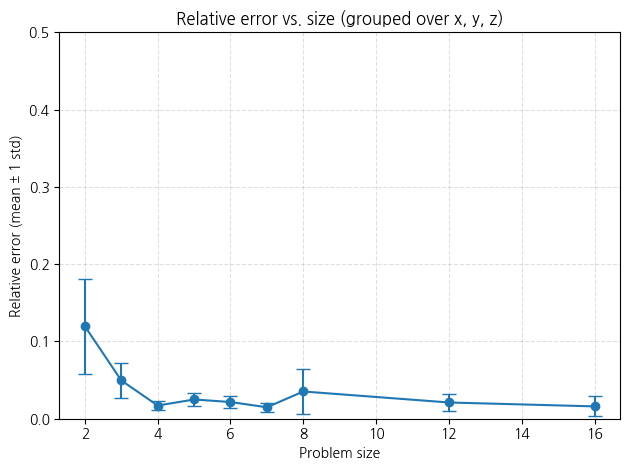

<Figure size 640x480 with 0 Axes>

In [30]:
plot_rel_error_by_size(results)
plt.savefig(filename.split(".")[0]+".png")
plt.show()

In [13]:
import numpy as np

sizes: deg=1, y: [0.18682832 0.07546754 0.03947016 0.05137423 0.05660744 0.03626464
 0.02280825 0.02311899 0.0224829 ]
sizes: deg=2, y: [0.43522444 0.22866927 0.13699216 0.14465633 0.06447801 0.05351853
 0.09954    0.08424792 0.04702531]
sizes: deg=0.5, y: [0.10318484 0.04687345 0.01629618 0.02412424 0.01965227 0.01360192
 0.02432981 0.01888013 0.01213775]


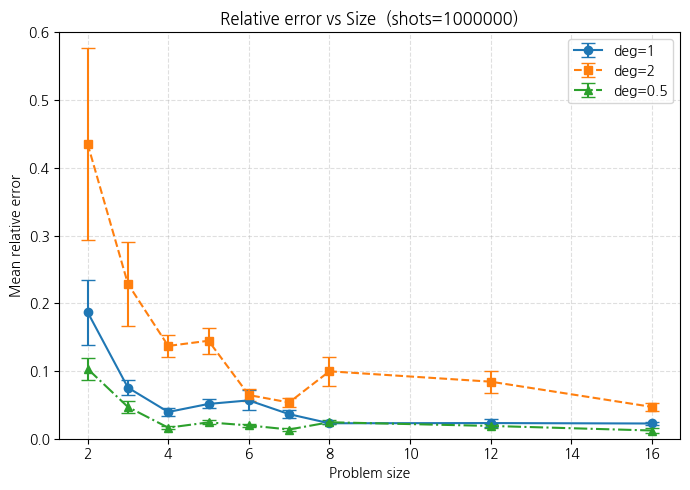

In [39]:
plt.close()
data_deg05 = parse_res2("res10_dist0.3_deg0.5_test10.txt")
data_deg1  = parse_res2("res6_dist0.3_deg1_test10.txt")
data_deg2  = parse_res2("res9_dist0.3_deg2_test10.txt")

plot_rel_error_three(data_deg05, data_deg1, data_deg2, target_shots=1_000_000, trim=True, ymax=0.6,
                     save_name = "HHL_size.png")

### Grouping by shots

In [36]:
from __future__ import annotations

from dataclasses import dataclass
from collections import defaultdict
from typing import List

import numpy as np
import matplotlib.pyplot as plt


@dataclass
class Record:
    size: int
    shots: int
    axis: str  # "x", "y", "z"
    true_val: float
    got_val: float
    rel_error: float | None


def parse_results(path: str) -> List[Record]:
    """Parse NLOS result file.

    Expected structure (repeats):

    size: 8
    shots: 10
    NLOS x: <true>, Got: <got>
    <rel_error>
    NLOS y: ...
    <rel_error>
    NLOS z: ...
    <rel_error>
    shots: 100
    ...

    Returns a list of Record objects.
    """
    records: List[Record] = []
    curr_size: int | None = None
    curr_shots: int | None = None

    with open(path, "r", encoding="utf-8") as f:
        # Strip blank lines
        lines = [ln.strip() for ln in f if ln.strip()]

    i = 0
    n = len(lines)

    while i < n:
        line = lines[i]

        # Update current size
        if line.startswith("size:"):
            try:
                curr_size = int(line.split(":", 1)[1].strip())
            except ValueError:
                curr_size = None
            i += 1
            continue

        # Update current shots
        if line.startswith("shots:"):
            try:
                curr_shots = int(line.split(":", 1)[1].strip())
            except ValueError:
                curr_shots = None
            i += 1
            continue

        # Parse NLOS line
        if line.startswith("NLOS"):
            # Example: "NLOS x: 39.9099..., Got: 61.0348..."
            header = line
            try:
                left, got_part = header.split("Got:")
                # 'NLOS x: 39.90..., '  and  '61.03...'
                axis = left.split()[1].rstrip(":")  # "x", "y", "z"
                true_str = left.split(":", 1)[1].split(",")[0].strip()
                got_str = got_part.strip()
                true_val = float(true_str)
                got_val = float(got_str)
            except Exception:
                # malformed line, skip
                i += 1
                continue

            # Next line should be relative error
            rel_error = None
            if i + 1 < n:
                rel_line = lines[i + 1]
                try:
                    rel_error = float(rel_line)
                except ValueError:
                    rel_error = None

            if curr_size is not None and curr_shots is not None:
                records.append(
                    Record(
                        size=curr_size,
                        shots=curr_shots,
                        axis=axis,
                        true_val=true_val,
                        got_val=got_val,
                        rel_error=rel_error,
                    )
                )

            i += 2
            continue

        # Anything else: skip
        i += 1

    return records


def plot_rel_error_by_shots(records: List[Record], filename = "plt.png",
                            trim=False, edge=1):
    """Group by shots and plot mean relative error with standard error bars.

    x-axis: shots (log scale)
    y-axis: average of rel_error over all NLOS components
    error bar: standard error of the mean (sample std / sqrt(n))
    """
    # 1. Group relative errors by shots
    grouped: dict[int, list[float]] = defaultdict(list)
    for r in records:
        if r.rel_error is not None:
            grouped[r.shots].append(r.rel_error)

    if not grouped:
        raise ValueError("No relative error data found to plot.")

    # 2. Compute mean and standard error for each shots value
    shots_vals = sorted(grouped.keys())
    means: list[float] = []
    ses: list[float] = []  # standard error

    for s in shots_vals:
        arr = np.array(grouped[s], dtype=float)

        if trim:
            n = len(arr)
            k_low, k_high = edge, edge
            if n > k_low + k_high:      # only trim if we have enough samples
                arr = np.sort(arr)
                arr = arr[k_low:n - k_high]

        means.append(arr.mean())
        if len(arr) > 1:
            std = arr.std(ddof=1)  # sample std
            se = std / np.sqrt(len(arr))
        else:
            se = 0.0
        ses.append(se)

    shots_arr = np.array(shots_vals, dtype=float)
    means_arr = np.array(means)
    ses_arr = np.array(ses)

    # 3. Plot
    fig, ax = plt.subplots()
    print(f"y: {means_arr}")

    ax.errorbar(
        shots_arr,
        means_arr,
        yerr=ses_arr,
        fmt="o-",
        capsize=4,
    )

    ax.set_xscale("log")
    ax.set_xlabel("Shots")
    ax.set_ylabel("Mean relative error")
    ax.set_title("NLOS Relative Error vs Shots (size=8)")
    ax.grid(True, which="both", linestyle="--", alpha=0.5)

    fig.tight_layout()
    return fig, ax


y: [2.16628946 0.56489593 0.10013134 0.0467244  0.04468159 0.04739262]


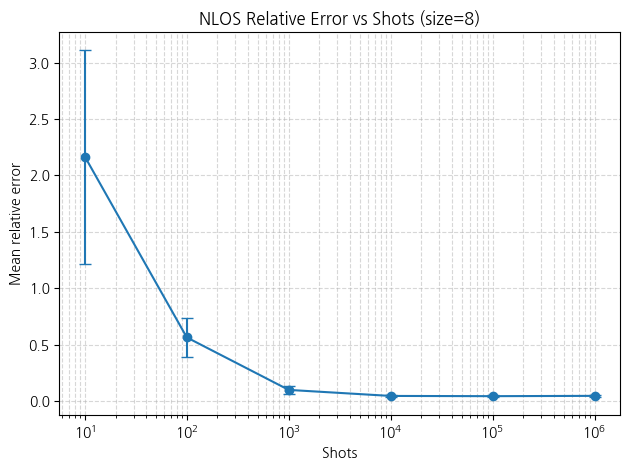

In [37]:
data = parse_results("shots_res7_dist0.3_deg1.txt")
fig, ax = plot_rel_error_by_shots(data, trim=True, edge=1)
fig.savefig("HHL_shots")
plt.show()

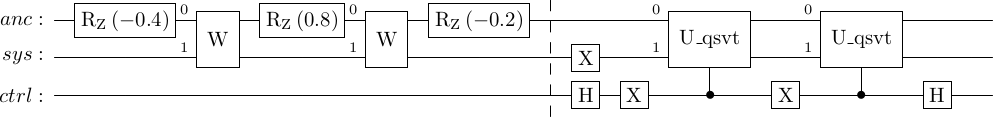

In [55]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister

def build_W_gate() -> QuantumCircuit:
    anc = QuantumRegister(1, "anc")
    sys = QuantumRegister(1, "sys")
    qc = QuantumCircuit(anc, sys, name="W")

    theta = np.pi / 3   # 예시값
    qc.cry(theta, anc[0], sys[0])
    qc.z(anc[0])
    return qc

def build_qsvt_core(phases):
    phases = list(phases)

    anc = QuantumRegister(1, "anc")
    sys = QuantumRegister(1, "sys")
    qc = QuantumCircuit(anc, sys, name="U_qsvt")

    W_gate = build_W_gate().to_gate(label="W")

    for phi in phases[:-1]:
        qc.rz(-2 * float(phi), anc[0])
        qc.append(W_gate, [anc[0], sys[0]])

    qc.rz(-2 * float(phases[-1]), anc[0])
    return qc

from IPython.display import display

def build_qsvt_full_demo(phases):
    phases = list(phases)

    # 전체 회로용 레지스터
    anc = QuantumRegister(1, "anc")
    sys = QuantumRegister(1, "sys")
    ctrl = QuantumRegister(1, "ctrl")
    qc = QuantumCircuit(anc, sys, ctrl, name="QSVT_full")

    # -------------------------
    # [블록 1] QSVT core만 보여주기
    # -------------------------
    core = build_qsvt_core(phases)      # anc, sys 두 줄짜리
    qc.compose(core, [anc[0], sys[0]], inplace=True)  # 구조 그대로 붙이기
    qc.barrier(anc, sys, ctrl)          # 시각적으로 구분

    # -------------------------
    # [블록 2] (U - U†)/2 imag-extractor
    #  - ctrl 큐빗 추가로 사용
    #  - 여기서는 U_qsvt를 하나의 게이트로 사용
    # -------------------------
    U = build_qsvt_core(phases).to_gate(label="U_qsvt")
    Ud = U.inverse()
    Ud.label = "U_qsvt†"

    # 예시로 sys를 |1>로 준비 (원하면 바꿔도 됨)
    qc.x(sys[0])

    # H on ctrl
    qc.h(ctrl[0])

    # ctrl = 1 일 때 U 적용
    qc.x(ctrl[0])
    qc.append(U.control(1), [ctrl[0], anc[0], sys[0]])
    qc.x(ctrl[0])

    # ctrl = 1 일 때 U† 적용
    qc.append(Ud.control(1), [ctrl[0], anc[0], sys[0]])

    # 마지막 H
    qc.h(ctrl[0])

    return qc

phases = [0.2, -0.4, 0.1]   # 아무 예시

qc_full = build_qsvt_full_demo(phases)
fig = qc_full.draw("latex", filename="QSVT_circ.png") 
display(fig)